In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
from saturation.utils import *

In [3]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "60g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

24/08/01 15:57:47 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
24/08/01 15:57:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/01 15:57:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [74]:
base_path = "/data/saturation/thesis_run_20240726_single_sims/bak"

colors = ["r", "b", "orange", "g"]
line_styles = ["-"]

configs_df = create_configs_df(read_configs(base_path, spark))
configs_pdf = configs_df.toPandas()

# For stats, select only fields we care about, alias them
data = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
data = data.select(
    "simulation_id",
    "ntot",
    "nobs",
    "mnnd",
    "z",
    "za",
    "radius_mean",
    "radius_stdev",
    F.col("areal_density").alias("ad"),
    F.log10("mnnd").alias("log_mnnd"),
    F.log10("nobs").alias("log_nobs"),
    F.log10("ntot").alias("log_ntot"),
).where(F.col("ntot") > 1)

# Join with configs to get simulation parameters
data = join_configs(data, configs_df, spark)

In [75]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/config*.yaml"):
    for run_config in read_config(Path(config_file))["run_configurations"]:
        configs_dict.update(run_config)

In [76]:
def plot_metric(
    data: pd.DataFrame,
    x_var: str,
    x_label: str,
    y_var: str,
    y_label: str,
    dotted_horizontal_lines: list[float] = None
):
    font_size = 16

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)

    simulation_ids = data.simulation_id.drop_duplicates()
    for idx, simulation_id in enumerate(simulation_ids):
        data_subset = data[data.simulation_id == simulation_id].sort_values("ntot")
        ax.plot(
            data_subset[x_var],
            data_subset[y_var],
            c=colors[idx % len(colors)],
            ls=line_styles[idx % len(line_styles)]
        )

    if dotted_horizontal_lines:
        for y_val in dotted_horizontal_lines:
            ax.axhline(y_val, color="r", linestyle="--")
    
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)

    return fig

## Plots of individual simulations vs N_tot, shallow slope

In [77]:
# Locate simulations with shallow slopes
configs_pdf[configs_pdf.slope == -1]

,erat,mrp,rmult,simulation_id,slope
4,9,0.5,1.5,2,-1.0
5,9,0.5,1.5,1,-1.0
11,9,0.5,1.5,3,-1.0


In [78]:
simulation_ids = list(configs_pdf[configs_pdf.slope == -1].simulation_id)

In [79]:
# Full configurations
[configs_dict[x] for x in simulation_ids]

[{'slope': -1.0,
  'erat': 9,
  'mrp': 0.5,
  'rmult': 1.5,
  'max_crater_radius': 500,
  'min_crater_radius': 3,
  'random_seed': 234,
  'simulation_name': 'shallow_slope_2',
  'spatial_hash_cell_size': 5,
  'stop_condition': {'ntot': 100000, 'name': 'ntot'},
  'study_region_padding': 250,
  'study_region_size': 2000},
 {'slope': -1.0,
  'erat': 9,
  'mrp': 0.5,
  'rmult': 1.5,
  'max_crater_radius': 500,
  'min_crater_radius': 3,
  'random_seed': 123,
  'simulation_name': 'shallow_slope_1',
  'spatial_hash_cell_size': 5,
  'stop_condition': {'ntot': 100000, 'name': 'ntot'},
  'study_region_padding': 250,
  'study_region_size': 2000},
 {'slope': -1.0,
  'erat': 9,
  'mrp': 0.5,
  'rmult': 1.5,
  'max_crater_radius': 500,
  'min_crater_radius': 3,
  'random_seed': 345,
  'simulation_name': 'shallow_slope_3',
  'spatial_hash_cell_size': 5,
  'stop_condition': {'ntot': 100000, 'name': 'ntot'},
  'study_region_padding': 250,
  'study_region_size': 2000}]

In [80]:
df = data.where(F.col("simulation_id").isin(simulation_ids)).orderBy("ntot").toPandas()

nobs line: 387.0


/tmp/ipykernel_3487799/3569301227.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


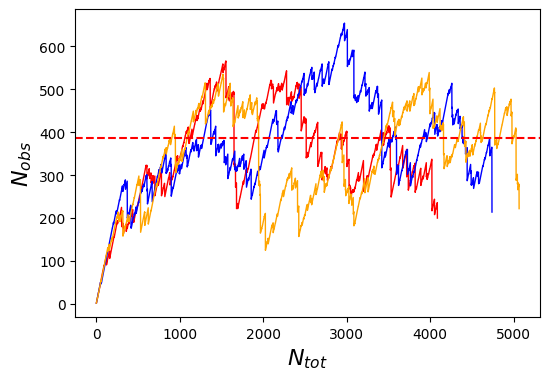

In [81]:
font_size = 16

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[df.ntot > 1250].nobs.median()
print(f"nobs line: {nobs_line}")

for idx, simulation_id in enumerate(simulation_ids):
    df_subset = df[df.simulation_id == simulation_id]
    plt1 = ax1.plot(
        df_subset.ntot,
        df_subset.nobs,
        label="$N_{obs}$",
        lw=1,
        c=colors[idx % len(colors)],
        ls=line_styles[idx % len(line_styles)]
    )

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

fig.savefig("figures/shallow_slope_ntot_nobs.png", bbox_inches="tight")
fig.show()

In [82]:
df[df.ntot == df.ntot.max()]

,slope,mrp,rmult,erat,simulation_id,ntot,nobs,mnnd,z,za,radius_mean,radius_stdev,ad,log_mnnd,log_nobs,log_ntot
13890,-1.0,0.5,1.5,9,3,5066,222,56.334167,-4.578894,1.07085,17.714814,43.009513,0.34557,1.750772,2.346353,3.704665


In [83]:
simulation_id = df[df.ntot == df.ntot.max()].simulation_id.squeeze()
target_ntots = [250, 500, 1000, 2500, 5000]
study_region_size = configs_dict[simulation_id]["study_region_size"]
study_region_padding = configs_dict[simulation_id]["study_region_padding"]

sim_name = configs_dict[simulation_id]["simulation_name"]
sim_path = f"{base_path}/{sim_name}"

stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")

states = {
    x: get_state_at_time(
        stats_df,
        craters_df,
        removals_df,
        simulation_id,
        x,
        study_region_size,
        study_region_padding,
        spark
    )
    for x in target_ntots
}

In [84]:
configs_dict[simulation_id]

{'slope': -1.0,
 'erat': 9,
 'mrp': 0.5,
 'rmult': 1.5,
 'max_crater_radius': 500,
 'min_crater_radius': 3,
 'random_seed': 345,
 'simulation_name': 'shallow_slope_3',
 'spatial_hash_cell_size': 5,
 'stop_condition': {'ntot': 100000, 'name': 'ntot'},
 'study_region_padding': 250,
 'study_region_size': 2000}

In [85]:
for ntot, state in states.items():
    state = states[ntot]
    alpha, sigma = estimate_cumulative_slope(
        state.radius,
        configs_dict[simulation_id]["min_crater_radius"],
        state.radius.max(),
        min_search_slope=0.0,
        max_search_slope=10.0)
    print(f"Ntot = {ntot}, alpha = {alpha:.3f}, sigma = {sigma:.3f}")

Ntot = 250, alpha = -1.006, sigma = 0.080
Ntot = 500, alpha = -0.966, sigma = 0.066
Ntot = 1000, alpha = -1.006, sigma = 0.061
Ntot = 2500, alpha = -0.878, sigma = 0.070
Ntot = 5000, alpha = -0.932, sigma = 0.053


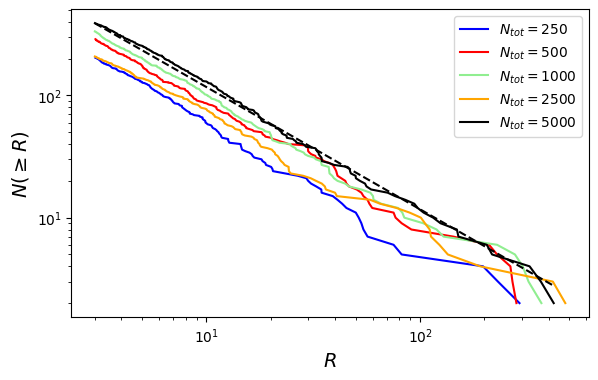

In [86]:
reference_slope = -1.0
intercept = max(state.shape[0] / state.radius.min()**reference_slope for state in states.values())
slope_intercept_line_styles = [
    (reference_slope, intercept, "--")
]
fig = plot_csfds_for_multiple_ntot(states, slope_intercept_line_styles=slope_intercept_line_styles)
fig.savefig("figures/shallow_slope_csfds.png", bbox_inches="tight")
# plt.xlim([5, 12])
# plt.ylim([1, 180])
plt.show()


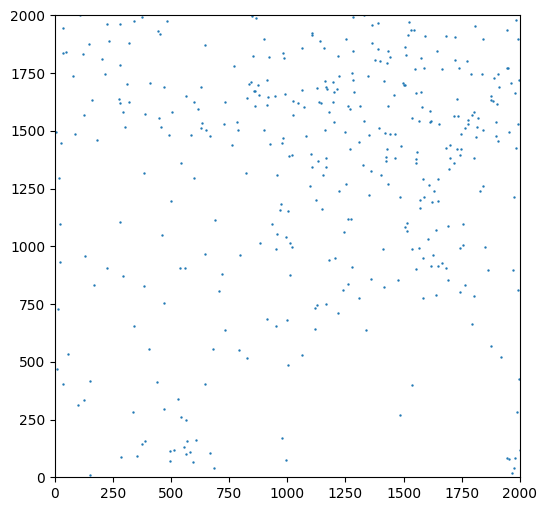

In [87]:
# Scatter plot of crater centers at a given ntot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.set_xlim([0, study_region_size])
ax.set_ylim([0, study_region_size])

s = states[max(states.keys())]

ax.scatter(s.x - study_region_padding, s.y - study_region_padding, s=0.5)

AD line: 0.3584165
log_mnnd line: 1.688275406444392


/tmp/ipykernel_3487799/798111154.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/798111154.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/798111154.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/798111154.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


radius_mean line: 15.199729210420095
radius_stdev line: 34.327184806918524


/tmp/ipykernel_3487799/798111154.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/798111154.py:74: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


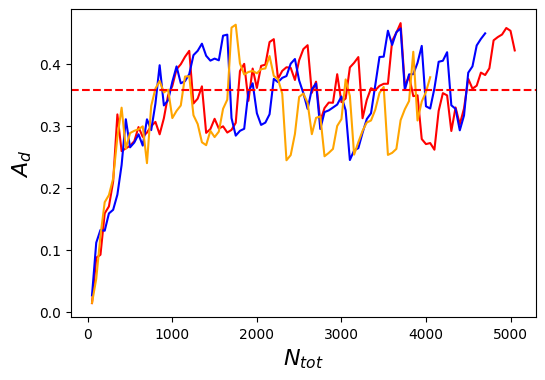

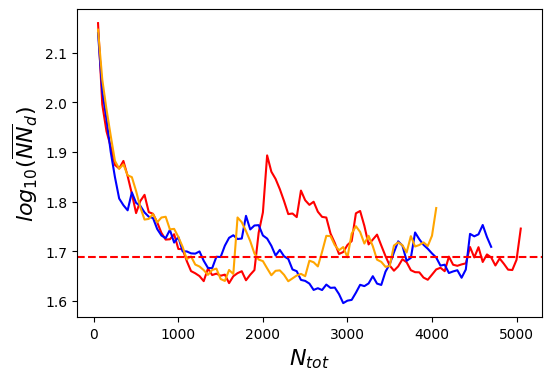

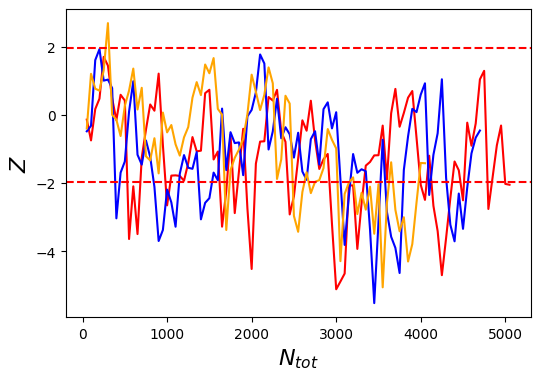

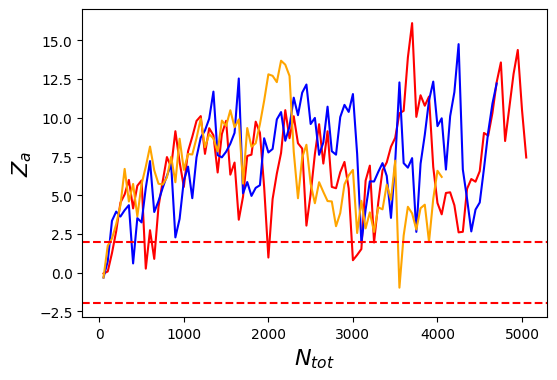

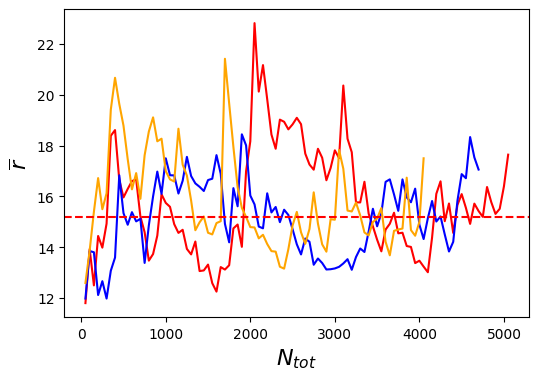

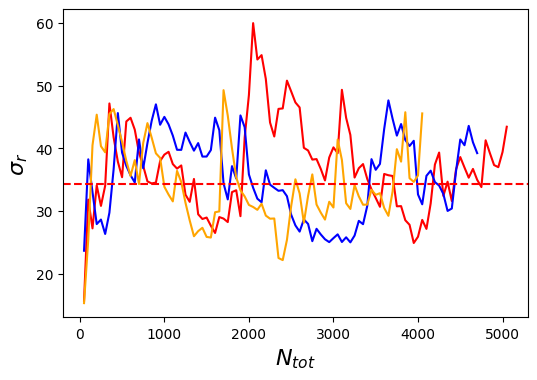

In [88]:
df = df[df.ntot % 50 == 0]

ad_line = df[df.ntot > 1000].ad.median()
print(f"AD line: {ad_line}")
fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "ad",
    "$A_d$",
    dotted_horizontal_lines=[ad_line]
)
fig.show()
fig.savefig("figures/shallow_slope_ntot_ad.png", bbox_inches="tight")

log_mnnd_line = df[df.ntot > 1500].log_mnnd.median()
print(f"log_mnnd line: {log_mnnd_line}")
fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "log_mnnd",
    "$log_{10}(\\overline{NN}_d)$",
    dotted_horizontal_lines=[log_mnnd_line]
)
fig.show()
fig.savefig("figures/shallow_slope_ntot_mnnd.png", bbox_inches="tight")

fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "z",
    "$Z$",
    dotted_horizontal_lines=[-1.96, 1.96]
)
fig.show()
fig.savefig("figures/shallow_slope_ntot_z.png", bbox_inches="tight")

fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "za",
    "$Z_a$",
    dotted_horizontal_lines=[-1.96, 1.96]
)
fig.show()
fig.savefig("figures/shallow_slope_ntot_za.png", bbox_inches="tight")

radius_mean_line = df[df.ntot > 1500].radius_mean.median()
print(f"radius_mean line: {radius_mean_line}")
fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "radius_mean",
    "$\\overline{r}$",
    dotted_horizontal_lines=[radius_mean_line]
)
fig.show()
fig.savefig("figures/shallow_slope_ntot_radius_mean.png", bbox_inches="tight")

radius_stdev_line = df[df.ntot > 1500].radius_stdev.median()
print(f"radius_stdev line: {radius_stdev_line}")
fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "radius_stdev",
    "$\\sigma_r$",
    dotted_horizontal_lines=[radius_stdev_line]
)
fig.show()
fig.savefig("figures/shallow_slope_ntot_radius_stdev.png", bbox_inches="tight")

## Plots of individual simulations vs N_tot, steep slope

In [89]:
configs_pdf[configs_pdf.slope == -4.0]

,erat,mrp,rmult,simulation_id,slope
0,9,0.5,1.5,23,-4.0
1,9,0.5,1.5,22,-4.0
8,9,0.5,1.5,21,-4.0


In [90]:
simulation_ids = list(configs_pdf[configs_pdf.slope == -4.0].simulation_id)

In [91]:
# Full configurations
[configs_dict[x] for x in simulation_ids]

[{'slope': -4.0,
  'erat': 9,
  'mrp': 0.5,
  'rmult': 1.5,
  'max_crater_radius': 500,
  'min_crater_radius': 3,
  'random_seed': 345,
  'simulation_name': 'steep_slope_3',
  'spatial_hash_cell_size': 5,
  'stop_condition': {'ntot': 100000, 'name': 'ntot'},
  'study_region_padding': 250,
  'study_region_size': 2000},
 {'slope': -4.0,
  'erat': 9,
  'mrp': 0.5,
  'rmult': 1.5,
  'max_crater_radius': 500,
  'min_crater_radius': 3,
  'random_seed': 234,
  'simulation_name': 'steep_slope_2',
  'spatial_hash_cell_size': 5,
  'stop_condition': {'ntot': 100000, 'name': 'ntot'},
  'study_region_padding': 250,
  'study_region_size': 2000},
 {'slope': -4.0,
  'erat': 9,
  'mrp': 0.5,
  'rmult': 1.5,
  'max_crater_radius': 500,
  'min_crater_radius': 3,
  'random_seed': 123,
  'simulation_name': 'steep_slope_1',
  'spatial_hash_cell_size': 5,
  'stop_condition': {'ntot': 100000, 'name': 'ntot'},
  'study_region_padding': 250,
  'study_region_size': 2000}]

In [92]:
df = data.where(F.col("simulation_id").isin(simulation_ids)).toPandas()

nobs line: 549.0


/tmp/ipykernel_3487799/1423201538.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


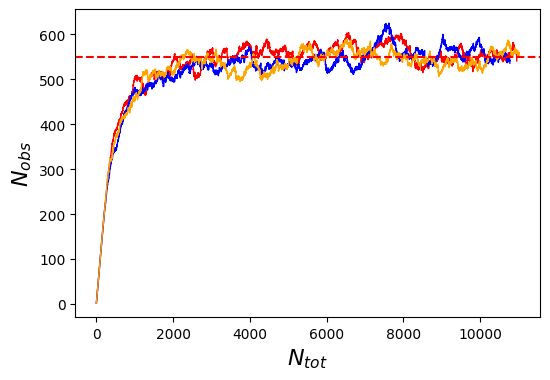

In [93]:
font_size = 16

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[df.ntot > 2500].nobs.median()
print(f"nobs line: {nobs_line}")

for idx, simulation_id in enumerate(simulation_ids):
    df_subset = df[df.simulation_id == simulation_id]
    plt1 = ax1.plot(
        df_subset.ntot,
        df_subset.nobs,
        label="$N_{obs}$",
        lw=1,
        c=colors[idx % len(colors)],
        ls=line_styles[idx % len(line_styles)]
    )

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

fig.savefig("figures/steep_slope_ntot_nobs.png", bbox_inches="tight")
fig.show()

In [94]:
simulation_id = df[df.ntot == df.ntot.max()].simulation_id.squeeze()
target_ntots = [250, 1000, 5000, 10000]
study_region_size = configs_dict[simulation_id]["study_region_size"]
study_region_padding = configs_dict[simulation_id]["study_region_padding"]

sim_name = configs_dict[simulation_id]["simulation_name"]
sim_path = f"{base_path}/{sim_name}"

stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")

states = {
    x: get_state_at_time(
        stats_df,
        craters_df,
        removals_df,
        simulation_id,
        x,
        study_region_size,
        study_region_padding,
        spark
    )
    for x in target_ntots
}

In [95]:
for ntot, state in states.items():
    state = states[ntot]
    alpha, sigma = estimate_cumulative_slope(
        state.radius,
        configs_dict[simulation_id]["min_crater_radius"],
        state.radius.max(),
        min_search_slope=0.0,
        max_search_slope=10.0)
    print(f"Ntot = {ntot}, alpha = {alpha:.3f}, sigma = {sigma:.3f}")

Ntot = 250, alpha = -4.511, sigma = 0.293
Ntot = 1000, alpha = -2.988, sigma = 0.144
Ntot = 5000, alpha = -2.150, sigma = 0.103
Ntot = 10000, alpha = -2.121, sigma = 0.102


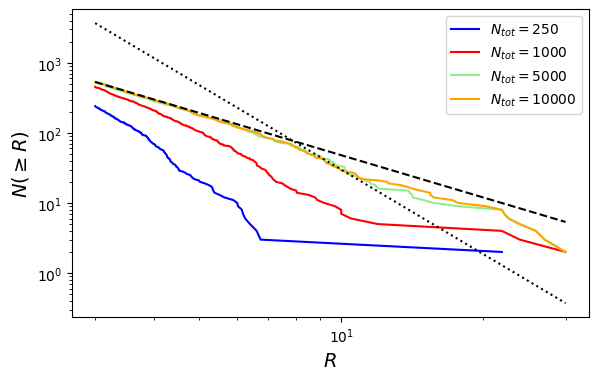

In [96]:
reference_slope = -2.0
intercept = max(state.shape[0] / state.radius.min()**reference_slope for state in states.values())
slope_intercept_line_styles = [
    (reference_slope, intercept, "--"),
    (-4.0, 3e5, "dotted")
]
fig = plot_csfds_for_multiple_ntot(states, slope_intercept_line_styles=slope_intercept_line_styles)
fig.savefig("figures/steep_slope_csfds.png", bbox_inches="tight")
plt.show()

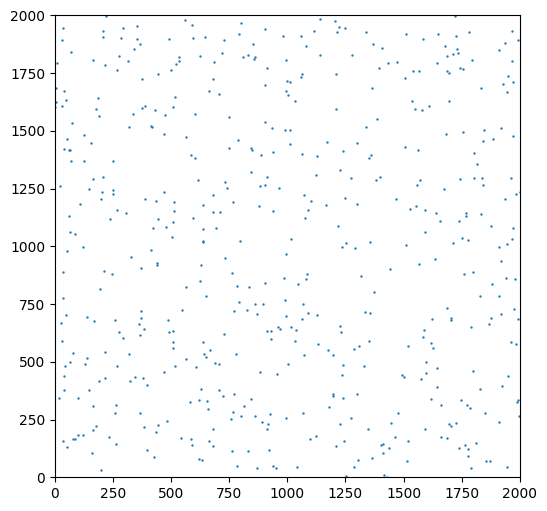

In [97]:
# Scatter plot of crater centers at a given ntot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.set_xlim([0, study_region_size])
ax.set_ylim([0, study_region_size])

s = states[max(states.keys())]

ax.scatter(s.x - study_region_padding, s.y - study_region_padding, s=0.5)

AD line: 0.015969875
log_mnnd line: 1.639161073017976


/tmp/ipykernel_3487799/4015219760.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/4015219760.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/4015219760.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/4015219760.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


radius_mean line: 5.256104489612632
radius_stdev line: 3.0935261130707854


/tmp/ipykernel_3487799/4015219760.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/4015219760.py:74: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


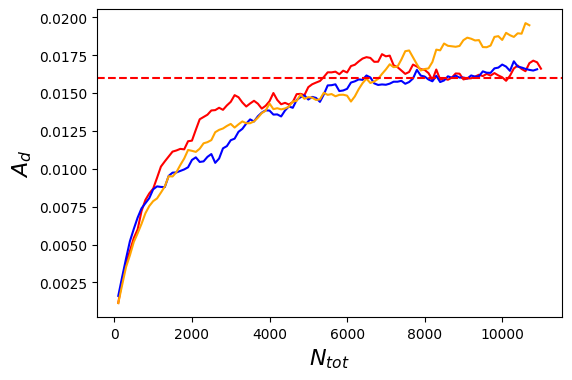

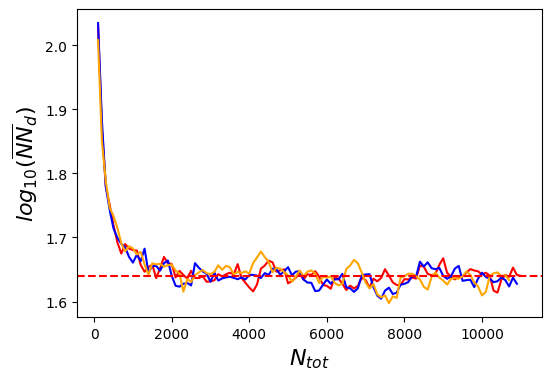

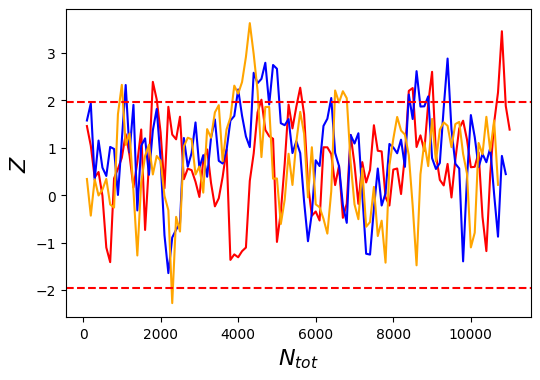

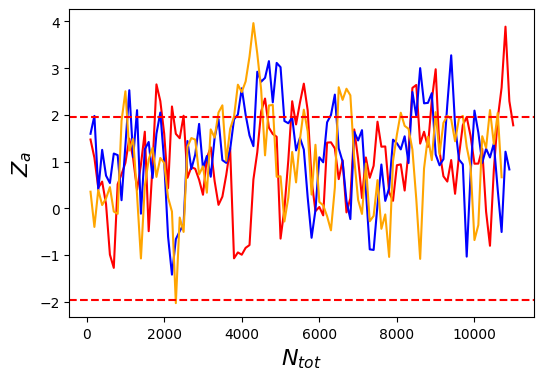

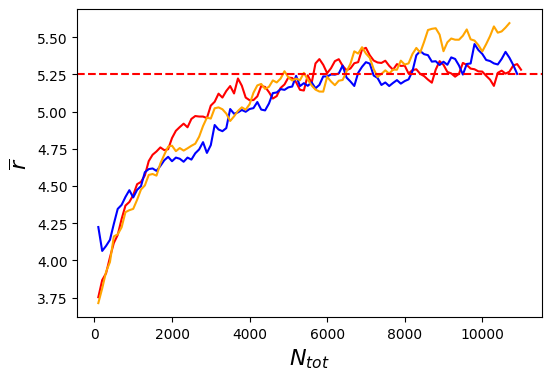

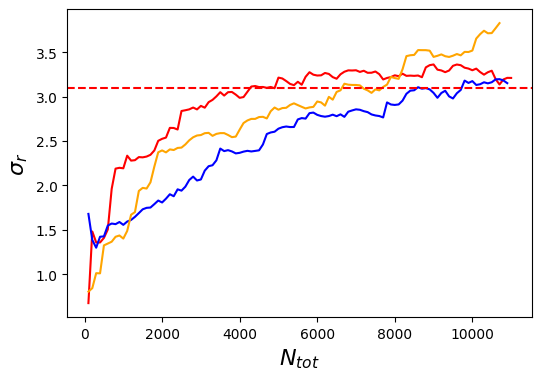

In [98]:
df = df[df.ntot % 100 == 0]

ad_line = df[df.ntot > 3000].ad.median()
print(f"AD line: {ad_line}")
fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "ad",
    "$A_d$",
    dotted_horizontal_lines=[ad_line]
)
fig.show()
fig.savefig("figures/steep_slope_ntot_ad.png", bbox_inches="tight")

log_mnnd_line = df[df.ntot > 1500].log_mnnd.median()
print(f"log_mnnd line: {log_mnnd_line}")
fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "log_mnnd",
    "$log_{10}(\\overline{NN}_d)$",
    dotted_horizontal_lines=[log_mnnd_line]
)
fig.show()
fig.savefig("figures/steep_slope_ntot_mnnd.png", bbox_inches="tight")

fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "z",
    "$Z$",
    dotted_horizontal_lines=[-1.96, 1.96]
)
fig.show()
fig.savefig("figures/steep_slope_ntot_z.png", bbox_inches="tight")

fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "za",
    "$Z_a$",
    dotted_horizontal_lines=[-1.96, 1.96]
)
fig.show()
fig.savefig("figures/steep_slope_ntot_za.png", bbox_inches="tight")

radius_mean_line = df[df.ntot > 3000].radius_mean.median()
print(f"radius_mean line: {radius_mean_line}")
fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "radius_mean",
    "$\\overline{r}$",
    dotted_horizontal_lines=[radius_mean_line]
)
fig.show()
fig.savefig("figures/steep_slope_ntot_radius_mean.png", bbox_inches="tight")

radius_stdev_line = df[df.ntot > 3000].radius_stdev.median()
print(f"radius_stdev line: {radius_stdev_line}")
fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "radius_stdev",
    "$\\sigma_r$",
    dotted_horizontal_lines=[radius_stdev_line]
)
fig.show()
fig.savefig("figures/steep_slope_ntot_radius_stdev.png", bbox_inches="tight")

## Plots of single simulations, high destruction, slope = -2.5

In [99]:
# Locate simulations with high destruction
configs_pdf[configs_pdf.simulation_id.between(40, 50)]

,erat,mrp,rmult,simulation_id,slope
2,15,0.75,1.9,41,-2.5
7,15,0.75,1.9,42,-2.5
9,15,0.75,1.9,43,-2.5


In [100]:
simulation_ids = list(configs_pdf[configs_pdf.simulation_id.between(40, 50)].simulation_id)

In [101]:
# Full configurations
[configs_dict[x] for x in simulation_ids]

[{'slope': -2.5,
  'erat': 15,
  'mrp': 0.75,
  'rmult': 1.9,
  'max_crater_radius': 500,
  'min_crater_radius': 3,
  'random_seed': 123,
  'simulation_name': 'mid_slope_high_destruction_1',
  'spatial_hash_cell_size': 5,
  'stop_condition': {'ntot': 100000, 'name': 'ntot'},
  'study_region_padding': 250,
  'study_region_size': 2000},
 {'slope': -2.5,
  'erat': 15,
  'mrp': 0.75,
  'rmult': 1.9,
  'max_crater_radius': 500,
  'min_crater_radius': 3,
  'random_seed': 234,
  'simulation_name': 'mid_slope_high_destruction_2',
  'spatial_hash_cell_size': 5,
  'stop_condition': {'ntot': 100000, 'name': 'ntot'},
  'study_region_padding': 250,
  'study_region_size': 2000},
 {'slope': -2.5,
  'erat': 15,
  'mrp': 0.75,
  'rmult': 1.9,
  'max_crater_radius': 500,
  'min_crater_radius': 3,
  'random_seed': 345,
  'simulation_name': 'mid_slope_high_destruction_3',
  'spatial_hash_cell_size': 5,
  'stop_condition': {'ntot': 100000, 'name': 'ntot'},
  'study_region_padding': 250,
  'study_region_siz

In [102]:
df = data.where(F.col("simulation_id").isin(simulation_ids)).orderBy("ntot").toPandas()

nobs line: 1083.0


/tmp/ipykernel_3487799/1299984200.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


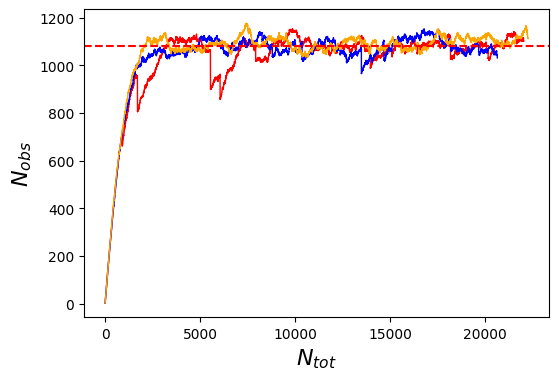

In [103]:
font_size = 16

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[df.ntot > 3000].nobs.median()
print(f"nobs line: {nobs_line}")

for idx, simulation_id in enumerate(simulation_ids):
    df_subset = df[df.simulation_id == simulation_id]
    plt1 = ax1.plot(
        df_subset.ntot,
        df_subset.nobs,
        label="$N_{obs}$",
        lw=1,
        c=colors[idx % len(colors)],
        ls=line_styles[idx % len(line_styles)]
    )

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

fig.savefig("figures/high_destruction_ntot_nobs.png", bbox_inches="tight")
fig.show()

In [104]:
df[df.ntot == df.ntot.max()]

,slope,mrp,rmult,erat,simulation_id,ntot,nobs,mnnd,z,za,radius_mean,radius_stdev,ad,log_mnnd,log_nobs,log_ntot
64900,-2.5,0.75,1.9,15,43,22245,1112,33.327267,7.103721,9.452663,6.04532,6.344913,0.063109,1.5228,3.046105,4.347232


In [141]:
# simulation_id = df[df.ntot == df.ntot.max()].simulation_id.squeeze()
simulation_id = 41
target_ntots = [500, 950, 5000, 20000]
study_region_size = configs_dict[simulation_id]["study_region_size"]
study_region_padding = configs_dict[simulation_id]["study_region_padding"]

sim_name = configs_dict[simulation_id]["simulation_name"]
sim_path = f"{base_path}/{sim_name}"

stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")

states = {
    x: get_state_at_time(
        stats_df,
        craters_df,
        removals_df,
        simulation_id,
        x,
        study_region_size,
        study_region_padding,
        spark
    )
    for x in target_ntots
}

In [142]:
configs_dict[simulation_id]

{'slope': -2.5,
 'erat': 15,
 'mrp': 0.75,
 'rmult': 1.9,
 'max_crater_radius': 500,
 'min_crater_radius': 3,
 'random_seed': 123,
 'simulation_name': 'mid_slope_high_destruction_1',
 'spatial_hash_cell_size': 5,
 'stop_condition': {'ntot': 100000, 'name': 'ntot'},
 'study_region_padding': 250,
 'study_region_size': 2000}

In [143]:
for ntot, state in states.items():
    state = states[ntot]
    alpha, sigma = estimate_cumulative_slope(
        state.radius,
        configs_dict[simulation_id]["min_crater_radius"],
        state.radius.max(),
        min_search_slope=0.0,
        max_search_slope=10.0)
    print(f"Ntot = {ntot}, alpha = {alpha:.3f}, sigma = {sigma:.3f}")

Ntot = 500, alpha = -2.608, sigma = 0.136
Ntot = 950, alpha = -2.422, sigma = 0.092
Ntot = 5000, alpha = -2.186, sigma = 0.066
Ntot = 20000, alpha = -1.938, sigma = 0.059


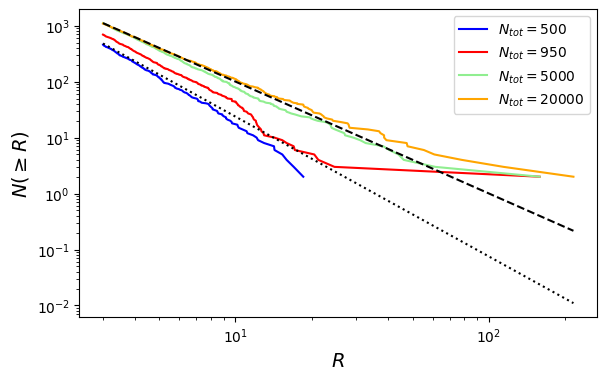

In [144]:
reference_slope = -2.0
intercept = max(state.shape[0] / state.radius.min()**reference_slope for state in states.values())
slope_intercept_line_styles = [
    (reference_slope, intercept, "--"),
    (-2.5, 7.5e3, "dotted")
]
fig = plot_csfds_for_multiple_ntot(states, slope_intercept_line_styles=slope_intercept_line_styles)
fig.savefig("figures/high_destruction_csfds.png", bbox_inches="tight")
plt.show()

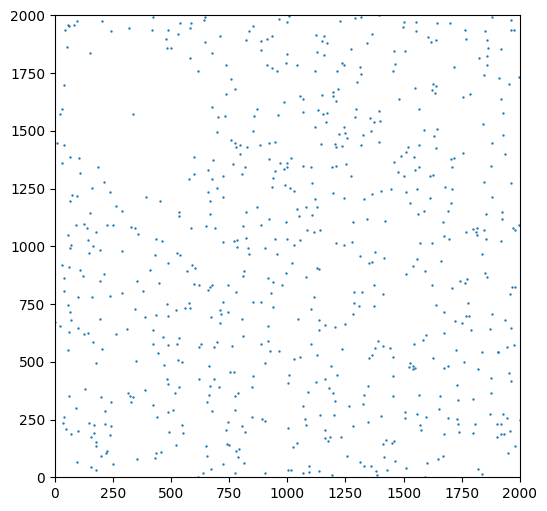

In [145]:
# Scatter plot of crater centers at a given ntot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.set_xlim([0, study_region_size])
ax.set_ylim([0, study_region_size])

s = states[max(states.keys())]

ax.scatter(s.x - study_region_padding, s.y - study_region_padding, s=0.5)

<>:24: SyntaxWarning: invalid escape sequence '\o'
<>:24: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_3487799/1451656910.py:24: SyntaxWarning: invalid escape sequence '\o'
  "$log_{10}(\overline{NN}_d)$",
/tmp/ipykernel_3487799/1451656910.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/1451656910.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/1451656910.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


AD line: 0.05808575
log_mnnd line: 1.519429569998856


/tmp/ipykernel_3487799/1451656910.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/1451656910.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/1451656910.py:75: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


radius_mean line: 5.908460817867733
radius_stdev line: 6.122224899172009


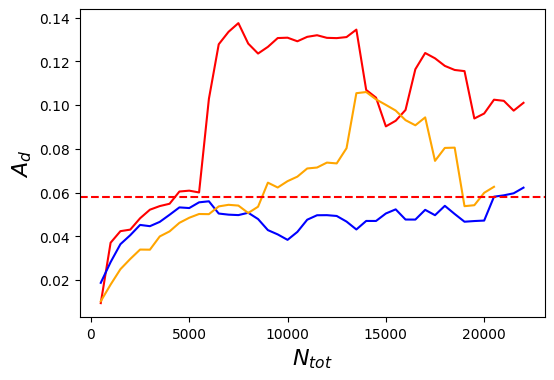

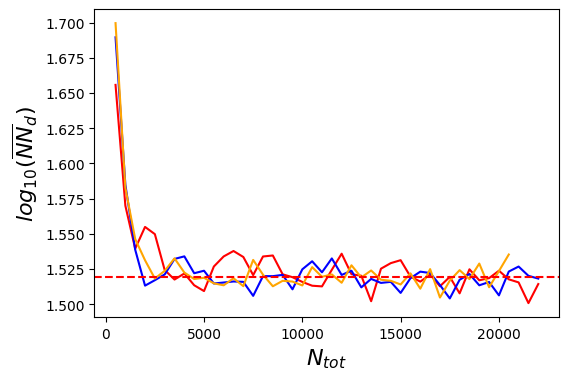

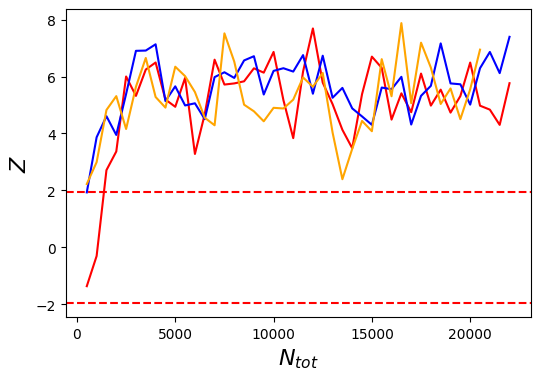

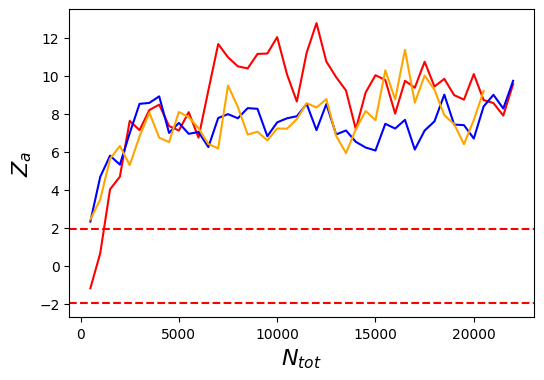

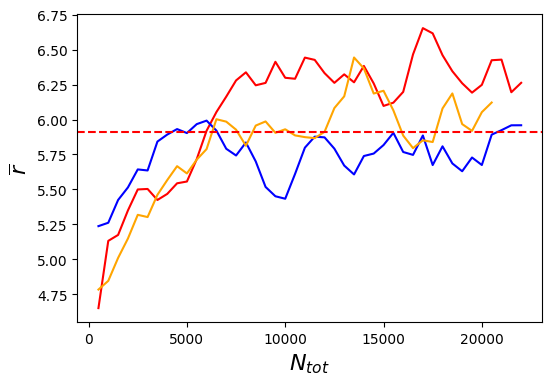

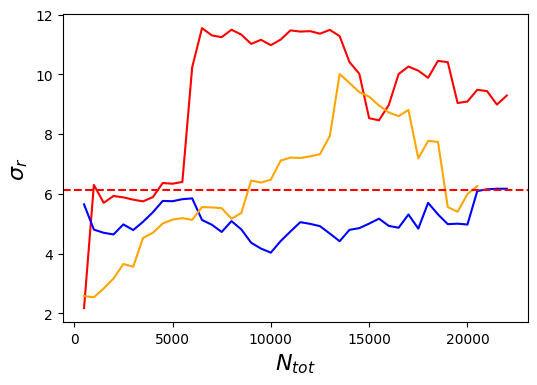

In [43]:
df = df.sort_values("ntot")
df = df[df.ntot % 500 == 0]

ad_line = df[df.ntot > 1000].ad.median()
print(f"AD line: {ad_line}")
fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "ad",
    "$A_d$",
    dotted_horizontal_lines=[ad_line]
)
fig.show()
fig.savefig("figures/high_destruction_ntot_ad.png", bbox_inches="tight")

log_mnnd_line = df[df.ntot > 1500].log_mnnd.median()
print(f"log_mnnd line: {log_mnnd_line}")
fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "log_mnnd",
    "$log_{10}(\overline{NN}_d)$",
    dotted_horizontal_lines=[log_mnnd_line]
)
fig.show()
fig.savefig("figures/high_destruction_ntot_mnnd.png", bbox_inches="tight")

fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "z",
    "$Z$",
    dotted_horizontal_lines=[-1.96, 1.96]
)
fig.show()
fig.savefig("figures/high_destruction_ntot_z.png", bbox_inches="tight")

fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "za",
    "$Z_a$",
    dotted_horizontal_lines=[-1.96, 1.96]
)
fig.show()
fig.savefig("figures/high_destruction_ntot_za.png", bbox_inches="tight")

radius_mean_line = df[df.ntot > 1500].radius_mean.median()
print(f"radius_mean line: {radius_mean_line}")
fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "radius_mean",
    "$\\overline{r}$",
    dotted_horizontal_lines=[radius_mean_line]
)
fig.show()
fig.savefig("figures/high_destruction_ntot_radius_mean.png", bbox_inches="tight")

radius_stdev_line = df[df.ntot > 1500].radius_stdev.median()
print(f"radius_stdev line: {radius_stdev_line}")
fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "radius_stdev",
    "$\\sigma_r$",
    dotted_horizontal_lines=[radius_stdev_line]
)
fig.show()
fig.savefig("figures/high_destruction_ntot_radius_stdev.png", bbox_inches="tight")

## Plots of single simulations, low destruction, slope = -2.5

In [44]:
# Locate simulations with shallow slopes
configs_pdf[configs_pdf.simulation_id.between(30, 40)]

,erat,mrp,rmult,simulation_id,slope
3,3,0.25,1.1,31,-2.5
6,3,0.25,1.1,32,-2.5
10,3,0.25,1.1,33,-2.5


In [45]:
simulation_ids = list(configs_pdf[configs_pdf.simulation_id.between(30, 40)].simulation_id)

In [46]:
# Full configurations
[configs_dict[x] for x in simulation_ids]

[{'slope': -2.5,
  'erat': 3,
  'mrp': 0.25,
  'rmult': 1.1,
  'max_crater_radius': 500,
  'min_crater_radius': 3,
  'random_seed': 123,
  'simulation_name': 'mid_slope_low_destruction_1',
  'spatial_hash_cell_size': 5,
  'stop_condition': {'ntot': 100000, 'name': 'ntot'},
  'study_region_padding': 250,
  'study_region_size': 2000},
 {'slope': -2.5,
  'erat': 3,
  'mrp': 0.25,
  'rmult': 1.1,
  'max_crater_radius': 500,
  'min_crater_radius': 3,
  'random_seed': 234,
  'simulation_name': 'mid_slope_low_destruction_2',
  'spatial_hash_cell_size': 5,
  'stop_condition': {'ntot': 100000, 'name': 'ntot'},
  'study_region_padding': 250,
  'study_region_size': 2000},
 {'slope': -2.5,
  'erat': 3,
  'mrp': 0.25,
  'rmult': 1.1,
  'max_crater_radius': 500,
  'min_crater_radius': 3,
  'random_seed': 345,
  'simulation_name': 'mid_slope_low_destruction_3',
  'spatial_hash_cell_size': 5,
  'stop_condition': {'ntot': 100000, 'name': 'ntot'},
  'study_region_padding': 250,
  'study_region_size': 20

In [47]:
df = data.where(F.col("simulation_id").isin(simulation_ids)).orderBy("ntot").toPandas()

nobs line: 25778.0


/tmp/ipykernel_3487799/354823409.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


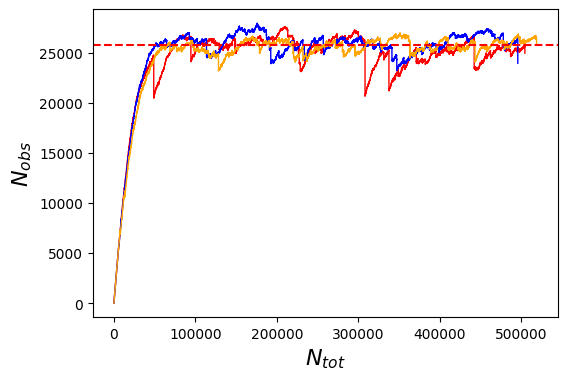

In [48]:
font_size = 16

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[df.ntot > 75000].nobs.median()
print(f"nobs line: {nobs_line}")

for idx, simulation_id in enumerate(simulation_ids):
    df_subset = df[df.simulation_id == simulation_id]
    plt1 = ax1.plot(
        df_subset.ntot,
        df_subset.nobs,
        label="$N_{obs}$",
        lw=1,
        c=colors[idx % len(colors)],
        ls=line_styles[idx % len(line_styles)]
    )

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

fig.savefig("figures/low_destruction_ntot_nobs.png", bbox_inches="tight")
fig.show()

In [49]:
df[df.ntot == df.ntot.max()]

,slope,mrp,rmult,erat,simulation_id,ntot,nobs,mnnd,z,za,radius_mean,radius_stdev,ad,log_mnnd,log_nobs,log_ntot
1519181,-2.5,0.25,1.1,3,33,518892,25941,6.640999,21.449452,839.482062,6.174589,7.898503,0.917526,0.822233,4.413987,5.715077


In [50]:
simulation_id = df[df.ntot == df.ntot.max()].simulation_id.squeeze()
target_ntots = [5000, 25000, 50000, 500000]
study_region_size = configs_dict[simulation_id]["study_region_size"]
study_region_padding = configs_dict[simulation_id]["study_region_padding"]

sim_name = configs_dict[simulation_id]["simulation_name"]
sim_path = f"{base_path}/{sim_name}"

stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")

states = {
    x: get_state_at_time(
        stats_df,
        craters_df,
        removals_df,
        simulation_id,
        x,
        study_region_size,
        study_region_padding,
        spark
    )
    for x in target_ntots
}

In [51]:
configs_dict[simulation_id]

{'slope': -2.5,
 'erat': 3,
 'mrp': 0.25,
 'rmult': 1.1,
 'max_crater_radius': 500,
 'min_crater_radius': 3,
 'random_seed': 345,
 'simulation_name': 'mid_slope_low_destruction_3',
 'spatial_hash_cell_size': 5,
 'stop_condition': {'ntot': 100000, 'name': 'ntot'},
 'study_region_padding': 250,
 'study_region_size': 2000}

In [52]:
for ntot, state in states.items():
    state = states[ntot]
    alpha, sigma = estimate_cumulative_slope(
        state.radius,
        configs_dict[simulation_id]["min_crater_radius"],
        state.radius.max(),
        min_search_slope=0.0,
        max_search_slope=10.0)
    print(f"Ntot = {ntot}, alpha = {alpha:.3f}, sigma = {sigma:.3f}")

Ntot = 5000, alpha = -2.491, sigma = 0.036
Ntot = 25000, alpha = -2.352, sigma = 0.018
Ntot = 50000, alpha = -2.127, sigma = 0.014
Ntot = 500000, alpha = -1.941, sigma = 0.012


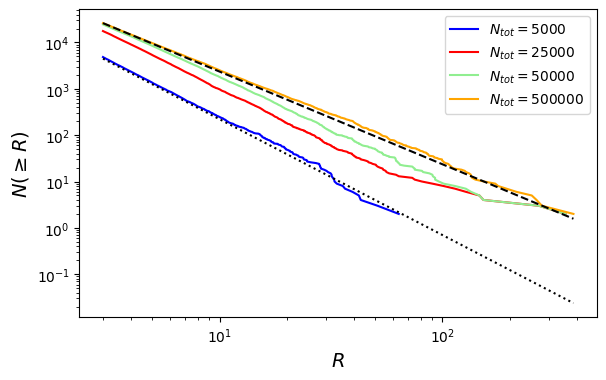

In [53]:
reference_slope = -2.0
intercept = max(state.shape[0] / state.radius.min()**reference_slope for state in states.values())
slope_intercept_line_styles = [
    (reference_slope, intercept, "--"),
    (-2.5, 7e4, "dotted"),
]
fig = plot_csfds_for_multiple_ntot(states, slope_intercept_line_styles=slope_intercept_line_styles)
fig.savefig("figures/low_destruction_csfds.png", bbox_inches="tight")
# plt.xlim([5, 12])
# plt.ylim([1, 180])
plt.show()


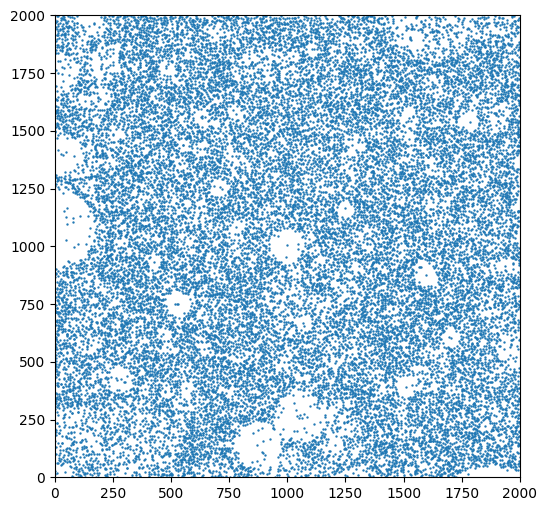

In [54]:
# Scatter plot of crater centers at a given ntot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.set_xlim([0, study_region_size])
ax.set_ylim([0, study_region_size])

s = states[max(states.keys())]

ax.scatter(s.x - study_region_padding, s.y - study_region_padding, s=0.5)

<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_3487799/375264270.py:23: SyntaxWarning: invalid escape sequence '\o'
  "$log_{10}(\overline{NN}_d)$",
/tmp/ipykernel_3487799/375264270.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/375264270.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/375264270.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


AD line: 0.91186525
log_mnnd line: 0.8247093989633396


/tmp/ipykernel_3487799/375264270.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/375264270.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/375264270.py:74: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


radius_mean line: 6.0726877850062735
radius_stdev line: 7.565828311143493


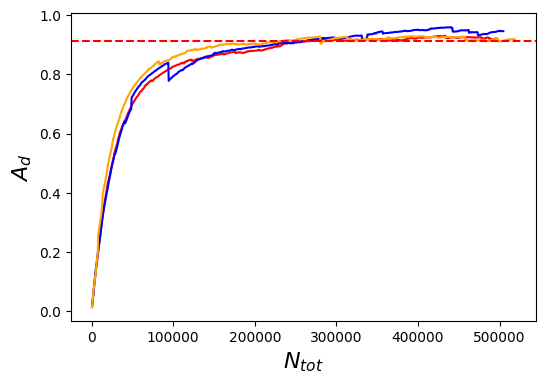

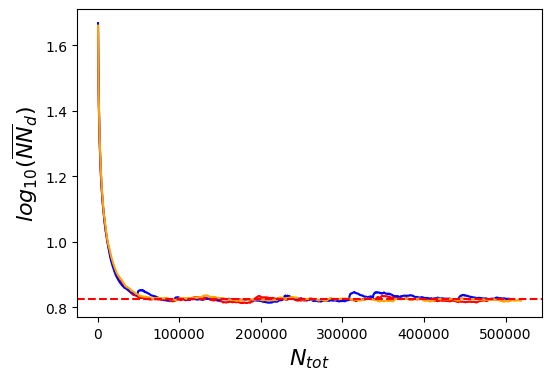

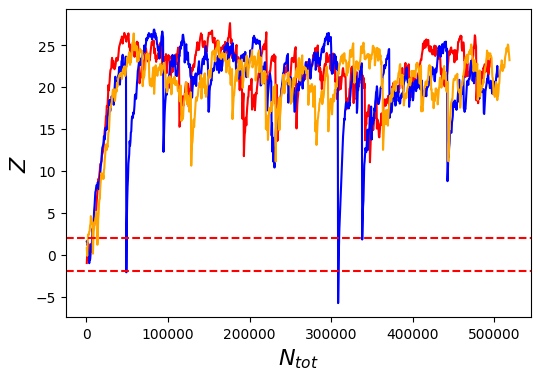

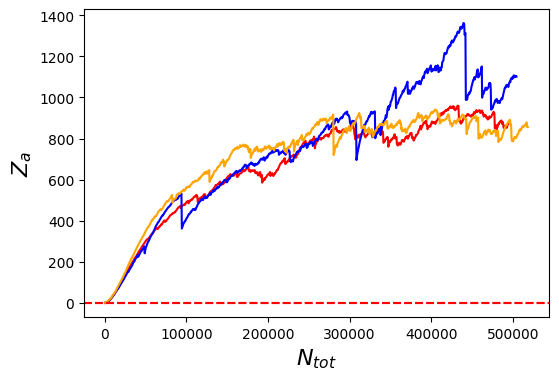

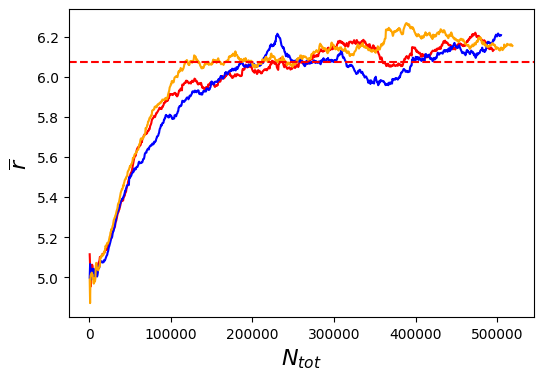

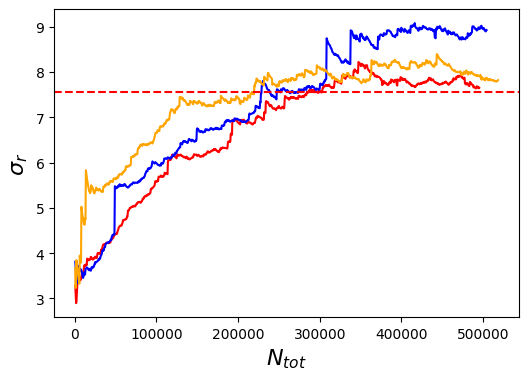

In [55]:
df = df[df.ntot % 500 == 0]

ad_line = df[df.ntot > 1000].ad.median()
print(f"AD line: {ad_line}")
fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "ad",
    "$A_d$",
    dotted_horizontal_lines=[ad_line]
)
fig.show()
fig.savefig("figures/low_destruction_ntot_ad.png", bbox_inches="tight")

log_mnnd_line = df[df.ntot > 1500].log_mnnd.median()
print(f"log_mnnd line: {log_mnnd_line}")
fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "log_mnnd",
    "$log_{10}(\overline{NN}_d)$",
    dotted_horizontal_lines=[log_mnnd_line]
)
fig.show()
fig.savefig("figures/low_destruction_ntot_mnnd.png", bbox_inches="tight")

fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "z",
    "$Z$",
    dotted_horizontal_lines=[-1.96, 1.96]
)
fig.show()
fig.savefig("figures/low_destruction_ntot_z.png", bbox_inches="tight")

fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "za",
    "$Z_a$",
    dotted_horizontal_lines=[-1.96, 1.96]
)
fig.show()
fig.savefig("figures/low_destruction_ntot_za.png", bbox_inches="tight")

radius_mean_line = df[df.ntot > 1500].radius_mean.median()
print(f"radius_mean line: {radius_mean_line}")
fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "radius_mean",
    "$\\overline{r}$",
    dotted_horizontal_lines=[radius_mean_line]
)
fig.show()
fig.savefig("figures/low_destruction_ntot_radius_mean.png", bbox_inches="tight")

radius_stdev_line = df[df.ntot > 1500].radius_stdev.median()
print(f"radius_stdev line: {radius_stdev_line}")
fig = plot_metric(
    df,
    "ntot",
    "$N_{tot}$",
    "radius_stdev",
    "$\\sigma_r$",
    dotted_horizontal_lines=[radius_stdev_line]
)
fig.show()
fig.savefig("figures/low_destruction_ntot_radius_stdev.png", bbox_inches="tight")

## Extended simulation, shallow slope

In [56]:
base_path = "/data/saturation/thesis_run_20240726_long_shallow_slope"

colors = ["r", "b", "orange", "g"]
line_styles = ["-"]

configs_df = create_configs_df(read_configs(base_path, spark))
configs_pdf = configs_df.toPandas()

# For stats, select only fields we care about, alias them
data = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
data = data.select(
    "simulation_id",
    "ntot",
    "nobs",
    "mnnd",
    "z",
    "za",
    "radius_mean",
    "radius_stdev",
    F.col("areal_density").alias("ad"),
    F.log10("mnnd").alias("log_mnnd"),
    F.log10("nobs").alias("log_nobs"),
    F.log10("ntot").alias("log_ntot"),
).where(F.col("ntot") > 1)

# Join with configs to get simulation parameters
data = join_configs(data, configs_df, spark)

In [57]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/thesis*.yaml"):
    for run_config in read_config(Path(config_file))["run_configurations"]:
        configs_dict.update(run_config)

In [58]:
# Locate simulations with shallow slopes
configs_pdf[configs_pdf.slope == -1]

,erat,mrp,rmult,simulation_id,slope
0,9,0.5,1.5,1,-1.0


In [59]:
simulation_ids = list(configs_pdf[configs_pdf.slope == -1].simulation_id)

In [60]:
# Full configurations
[configs_dict[x] for x in simulation_ids]

[{'slope': -1.0,
  'erat': 9,
  'mrp': 0.5,
  'rmult': 1.5,
  'max_crater_radius': 500,
  'min_crater_radius': 3,
  'random_seed': 123,
  'simulation_name': 'long_shallow_slope',
  'spatial_hash_cell_size': 5,
  'stop_condition': {'ntot': 10000000, 'name': 'ntot'},
  'study_region_padding': 250,
  'study_region_size': 2000}]

In [61]:
df = data.where(F.col("simulation_id").isin(simulation_ids)).orderBy("ntot").toPandas()

nobs line: 386.0


/tmp/ipykernel_3487799/2442785323.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_subset = df[df.ntot % 50000 == 1][df.simulation_id == simulation_id]
/tmp/ipykernel_3487799/2442785323.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


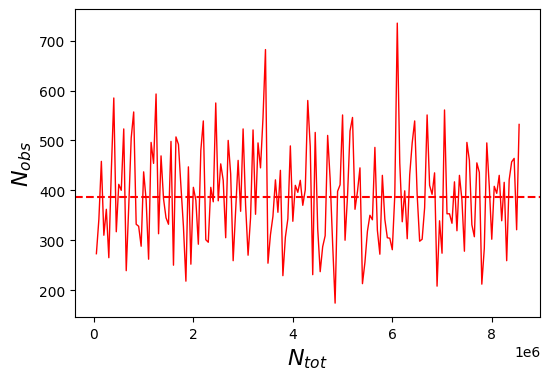

In [62]:
font_size = 16

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[df.ntot > 50000].nobs.median()
print(f"nobs line: {nobs_line}")

for idx, simulation_id in enumerate(simulation_ids):
    df_subset = df[df.ntot % 50000 == 1][df.simulation_id == simulation_id]
    plt1 = ax1.plot(
        df_subset.ntot,
        df_subset.nobs,
        label="$N_{obs}$",
        lw=1,
        c=colors[idx % len(colors)],
        ls=line_styles[idx % len(line_styles)]
    )

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

fig.savefig("figures/long_shallow_slope_ntot_nobs.png", bbox_inches="tight")
fig.show()

In [63]:
df[df.ntot == df.ntot.max()]

,slope,mrp,rmult,erat,simulation_id,ntot,nobs,mnnd,z,za,radius_mean,radius_stdev,ad,log_mnnd,log_nobs,log_ntot
8599998,-1.0,0.5,1.5,9,1,8600000,410,44.893262,-3.524295,4.829728,15.293276,34.366774,0.346738,1.652181,2.612784,6.934498


In [64]:
simulation_id = df[df.ntot == df.ntot.max()].simulation_id.squeeze()
target_ntots = [500, 5000, 50000, 500000, 8000000]
study_region_size = configs_dict[simulation_id]["study_region_size"]
study_region_padding = configs_dict[simulation_id]["study_region_padding"]

sim_name = configs_dict[simulation_id]["simulation_name"]
sim_path = f"{base_path}/{sim_name}"

stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")

states = {
    x: get_state_at_time(
        stats_df,
        craters_df,
        removals_df,
        simulation_id,
        x,
        study_region_size,
        study_region_padding,
        spark
    )
    for x in target_ntots
}

In [65]:
configs_dict[simulation_id]

{'slope': -1.0,
 'erat': 9,
 'mrp': 0.5,
 'rmult': 1.5,
 'max_crater_radius': 500,
 'min_crater_radius': 3,
 'random_seed': 123,
 'simulation_name': 'long_shallow_slope',
 'spatial_hash_cell_size': 5,
 'stop_condition': {'ntot': 10000000, 'name': 'ntot'},
 'study_region_padding': 250,
 'study_region_size': 2000}

In [66]:
for ntot, state in states.items():
    state = states[ntot]
    alpha, sigma = estimate_cumulative_slope(
        state.radius,
        configs_dict[simulation_id]["min_crater_radius"],
        state.radius.max(),
        min_search_slope=0.0,
        max_search_slope=10.0)
    print(f"Ntot = {ntot}, alpha = {alpha:.3f}, sigma = {sigma:.3f}")

Ntot = 500, alpha = -1.092, sigma = 0.078
Ntot = 5000, alpha = -1.018, sigma = 0.069
Ntot = 50000, alpha = -0.911, sigma = 0.062
Ntot = 500000, alpha = -0.906, sigma = 0.050
Ntot = 8000000, alpha = -1.050, sigma = 0.061


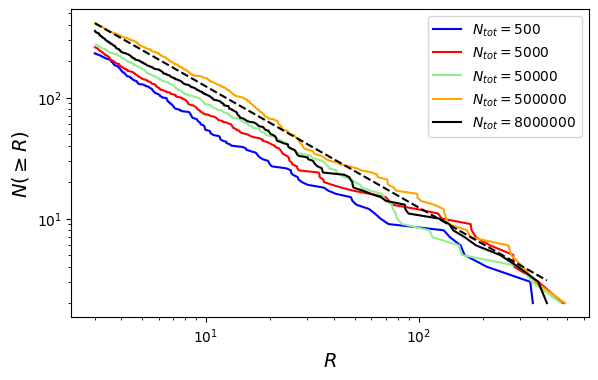

In [67]:
reference_slope = -1.0
intercept = max(state.shape[0] / state.radius.min()**reference_slope for state in states.values())
slope_intercept_line_styles = [
    (reference_slope, intercept, "--")
]
fig = plot_csfds_for_multiple_ntot(states, slope_intercept_line_styles=slope_intercept_line_styles)
fig.savefig("figures/long_shallow_slope_csfds.png", bbox_inches="tight")
plt.show()


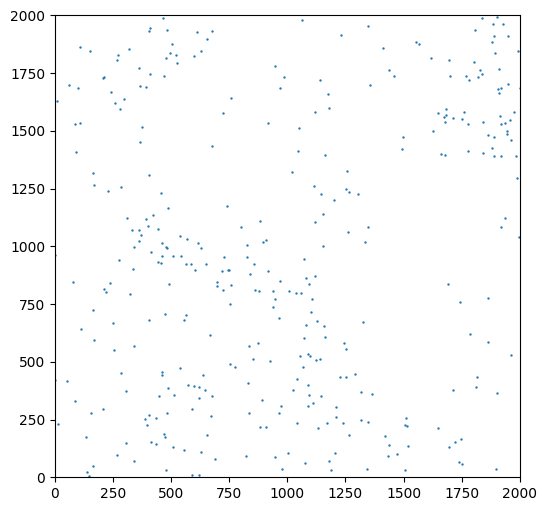

In [68]:
# Scatter plot of crater centers at a given ntot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.set_xlim([0, study_region_size])
ax.set_ylim([0, study_region_size])

s = states[max(states.keys())]

ax.scatter(s.x - study_region_padding, s.y - study_region_padding, s=0.5)

AD line: 0.3522535
log_mnnd line: 1.6831073848237184


/tmp/ipykernel_3487799/2599993439.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/2599993439.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/2599993439.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/2599993439.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


radius_mean line: 15.26680213958025
radius_stdev line: 35.380943207084016


/tmp/ipykernel_3487799/2599993439.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3487799/2599993439.py:74: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


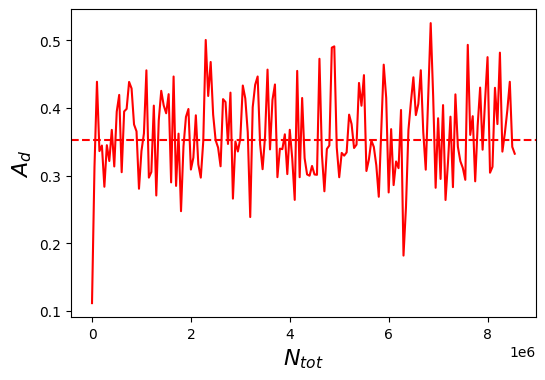

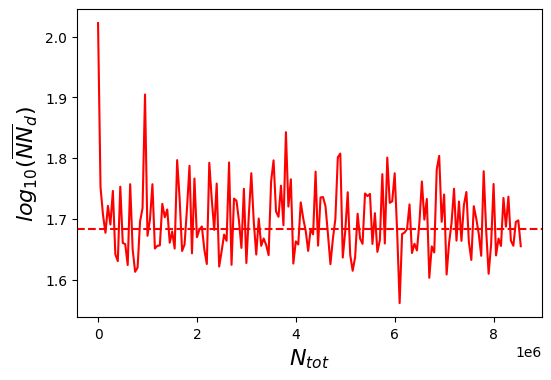

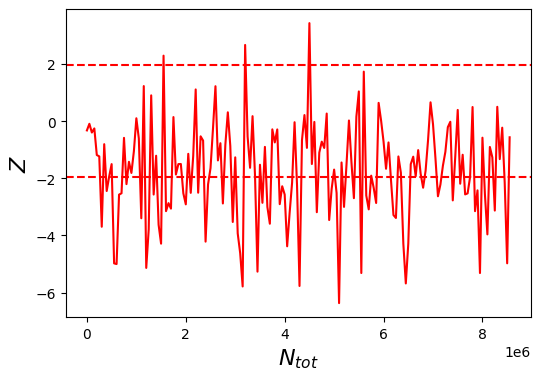

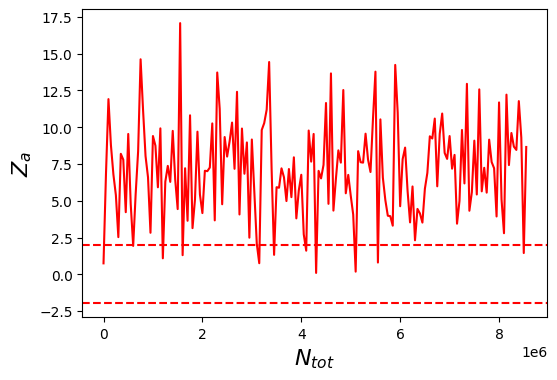

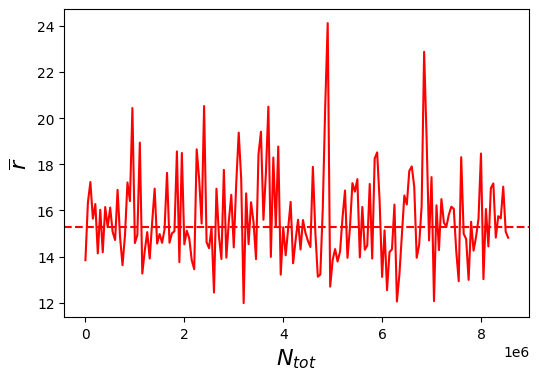

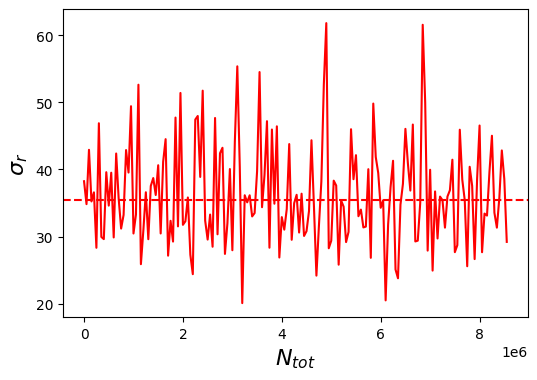

In [71]:
df_sampled = df[df.ntot % 50000 == 100]

ad_line = df_sampled[df_sampled.ntot > 50000].ad.median()
print(f"AD line: {ad_line}")
fig = plot_metric(
    df_sampled,
    "ntot",
    "$N_{tot}$",
    "ad",
    "$A_d$",
    dotted_horizontal_lines=[ad_line]
)
fig.show()
fig.savefig("figures/long_shallow_slope_ntot_ad.png", bbox_inches="tight")

log_mnnd_line = df_sampled[df_sampled.ntot > 50000].log_mnnd.median()
print(f"log_mnnd line: {log_mnnd_line}")
fig = plot_metric(
    df_sampled,
    "ntot",
    "$N_{tot}$",
    "log_mnnd",
    "$log_{10}(\\overline{NN}_d)$",
    dotted_horizontal_lines=[log_mnnd_line]
)
fig.show()
fig.savefig("figures/long_shallow_slope_ntot_mnnd.png", bbox_inches="tight")

fig = plot_metric(
    df_sampled,
    "ntot",
    "$N_{tot}$",
    "z",
    "$Z$",
    dotted_horizontal_lines=[-1.96, 1.96]
)
fig.show()
fig.savefig("figures/long_shallow_slope_ntot_z.png", bbox_inches="tight")

fig = plot_metric(
    df_sampled,
    "ntot",
    "$N_{tot}$",
    "za",
    "$Z_a$",
    dotted_horizontal_lines=[-1.96, 1.96]
)
fig.show()
fig.savefig("figures/long_shallow_slope_ntot_za.png", bbox_inches="tight")

radius_mean_line = df_sampled[df_sampled.ntot > 50000].radius_mean.median()
print(f"radius_mean line: {radius_mean_line}")
fig = plot_metric(
    df_sampled,
    "ntot",
    "$N_{tot}$",
    "radius_mean",
    "$\\overline{r}$",
    dotted_horizontal_lines=[radius_mean_line]
)
fig.show()
fig.savefig("figures/long_shallow_slope_ntot_radius_mean.png", bbox_inches="tight")

radius_stdev_line = df_sampled[df_sampled.ntot > 50000].radius_stdev.median()
print(f"radius_stdev line: {radius_stdev_line}")
fig = plot_metric(
    df_sampled,
    "ntot",
    "$N_{tot}$",
    "radius_stdev",
    "$\\sigma_r$",
    dotted_horizontal_lines=[radius_stdev_line]
)
fig.show()
fig.savefig("figures/long_shallow_slope_ntot_radius_stdev.png", bbox_inches="tight")